# Spark Tasks

## Imports and environment initialization

In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
!pip install graphframes

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u412-ga-1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [2]:
import os
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, Row, types as T
from pyspark.sql.functions import col, rank, row_number, split, regexp_replace, collect_list, hash as spark_hash, concat_ws, concat, lit, when, abs, explode, desc, size
from pyspark.sql.types import ArrayType, StructType, StructField, StringType, LongType, DoubleType, IntegerType
from pyspark.sql.functions import udf
import numpy as np
from collections import Counter
from random import shuffle
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import MinHashLSH
import pandas as pd
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from graphframes import GraphFrame
import networkx as nx
import matplotlib.pyplot as plt
from itertools import chain

## Create & Configure Session

In [3]:
def create_session():
    # create the session
    conf = SparkConf()
    conf.setAppName("DIS-lab-1")    # Sets name of the Spark Application
    conf.setMaster("local[16]")    # Master URL. In this case local[*] uses all the available cores in the machine
    conf.set("spark.driver.memory", "10G")   # Memory allocated to driver process
    conf.set("spark.driver.maxResultSize", "6G")    # Maximum size of results that can be returned to driver
    conf.set("spark.executor.instances", "4")
    conf.set("spark.executor.cores", "4")
    conf.set("spark.executor.memory", "4G")    # Memory allocated to each executor
    conf.set("spark.network.timeout", "600s")  # Increase network timeout
    conf.set("spark.executor.heartbeatInterval", "60s")  # Increase heartbeat interval
    conf.set("spark.rpc.message.maxSize", "512")  # Increase max message size
    conf.set("spark.driver.maxResultSize", "4G")  # Increase driver max result size
    conf.set("spark.sql.broadcastTimeout", "600")  # Increase broadcast timeout
    conf.set("spark.sql.shuffle.partitions", "200")  # Increase the number of shuffle partitions
    conf.set("spark.yarn.executor.memoryOverhead", "2048")  # Increase memory overhead
    conf.set("spark.memory.offHeap.enabled","true")
    conf.set("spark.memory.offHeap.size","10g")
    conf.set("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.0-s_2.12")  # Add GraphFrames to the spark configuration
    conf.set("spark.hadoop.fs.file.impl", "org.apache.hadoop.fs.LocalFileSystem")  # Ensure local file system is used for checkpointing

    sc = pyspark.SparkContext(conf=conf)    # Initializes the Spark context with this specific configuration
    spark = SparkSession.builder.config(conf=sc.getConf()).getOrCreate()    # Creates Spark session

    # Set checkpoint directory
    sc.setCheckpointDir("checkpoints")

    return sc, spark

try:
    if 'sc' in globals() and sc is not None:
        sc.stop()
        print("--Stopped existing SparkContext")
    if 'spark' in globals() and isinstance(spark, SparkSession):
        spark.stop()
        print("--Stopped existing SparkSession")
except Exception as e:
    print(f"Error stopping existing Spark session or context: {e}")

# Create a new Spark session
sc, spark = create_session()
print("Spark session created successfully!")
spark

Spark session created successfully!


## Load and Split Data

### Load the data from the CSVs

In [4]:
logs = spark.read.csv('merged_users.csv', header=True, inferSchema=True)

### Split the data into 5 separate columns

In [5]:
logs_splitted = logs \
    .withColumn("from_server", regexp_replace(split(col("Logs"), ", ").getItem(0), "[<>]", "")) \
    .withColumn("to_server", split(col("Logs"), ", ").getItem(1)) \
    .withColumn("time", split(col("Logs"), ", ").getItem(2)) \
    .withColumn("action", split(col("Logs"), ", ").getItem(3)) \
    .withColumn("process_id", regexp_replace(split(col("Logs"), ", ").getItem(4), "[<>]", "")) \
    .drop("Logs")

# Cast the "time" and "process_id" columns to integers
logs_casted = logs_splitted \
    .withColumn("time", col("time").cast("integer")) \
    .withColumn("process_id", col("process_id").cast("integer"))

In [6]:
logs_splitted.show(1, truncate=False)

+-----------+-----------+----+-------+----------+
|from_server|to_server  |time|action |process_id|
+-----------+-----------+----+-------+----------+
|user       |ui_server_2|372 |Request|0000000001|
+-----------+-----------+----+-------+----------+
only showing top 1 row



## Group data

### Group by process_id

In [7]:
logs_grouped = logs_casted.groupBy("process_id").agg(
    collect_list("from_server").alias("from_servers"),
    collect_list("to_server").alias("to_servers"),
    collect_list("time").alias("times"),
    collect_list("action").alias("actions")
)

In [8]:
logs_grouped.show(6, truncate=False)

+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Sort all the column items based on 'from_server' so the sub-processes are in the right order

In [9]:
def sort_lists_time(times, from_servers, to_servers, actions):
    combined = list(zip(times, from_servers, to_servers, actions))
    sorted_combined = sorted(combined, key=lambda x: x[0])

    # Remove the second half of each list since it contains duplicte names
    half_length = len(sorted_combined) // 2
    truncated_combined = sorted_combined[:half_length]

    times_sorted, from_servers_sorted, to_servers_sorted, actions_sorted = zip(*truncated_combined)
    return list(times_sorted), list(from_servers_sorted), list(to_servers_sorted), list(actions_sorted)

def sort_lists_from_server(times, from_servers, to_servers, actions):
    # First sort by time
    combined = list(zip(times, from_servers, to_servers, actions))
    sorted_combined = sorted(combined, key=lambda x: x[0])  # Sort by times (x[0])

    # Remove the second half of each list since it contains duplicte names
    half_length = len(sorted_combined) // 2
    truncated_combined = sorted_combined[:half_length]

    times_sorted, from_servers_sorted, to_servers_sorted, actions_sorted = zip(*truncated_combined)

    combined = list(zip(times_sorted, from_servers_sorted, to_servers_sorted, actions_sorted))
    sorted_combined = sorted(combined, key=lambda x: x[1])
    times_sorted, from_servers_sorted, to_servers_sorted, actions_sorted = zip(*sorted_combined)
    return list(times_sorted), list(from_servers_sorted), list(to_servers_sorted), list(actions_sorted)

# Define the schema for the sorted columns
sorted_lists_schema = StructType([
    StructField("times", ArrayType(LongType()), nullable=True),
    StructField("from_servers", ArrayType(StringType()), nullable=True),
    StructField("to_servers", ArrayType(StringType()), nullable=True),
    StructField("actions", ArrayType(StringType()), nullable=True)
])

# Register the function as a UDF
sort_lists_udf = udf(sort_lists_from_server, sorted_lists_schema)

# Apply the UDF to sort the lists based on the "times" column
logs_grouped = logs_grouped.withColumn("sorted_lists", sort_lists_udf("times", "from_servers", "to_servers", "actions"))

# Split the sorted lists into separate columns
logs_grouped = logs_grouped.withColumn("times", col("sorted_lists.times")) \
                           .withColumn("from_servers", col("sorted_lists.from_servers")) \
                           .withColumn("to_servers", col("sorted_lists.to_servers")) \
                           .withColumn("actions", col("sorted_lists.actions")) \
                           .drop("sorted_lists")

### Create 'process_string' column with a string of all the 'from_servers'

In [10]:
'''
Using the withColumn method to create a new column "process_string".
The concat_ws function concatenates multiple column values into a single string, separated by a comma.
col("from_servers"): Selects the column "from_servers".
col("to_servers"): Selects the column "to_servers".
col("times"): Selects the column "times".
col("actions"): Selects the column "actions".
The concatenated string is stored in the new column "process_string".
'''

logs_grouped = logs_grouped.withColumn(
    "process_string",
    concat_ws(",", col("from_servers"))
)

# LSH and Connected Components Approach

## 1. Create shingles

### 1.1. Pre-processing before shingles

#### Find common sub-string

In [11]:
def get_all_substrings(string, min_length):
    length = len(string)
    return [string[i:j] for i in range(length) for j in range(i + min_length, length + 1)]


def find_common_substring(server_names, min_length=3, min_occurrences_ratio=0.6):
    substr_counter = Counter()
    total_names = len(server_names)
    min_occurrences = int(total_names * min_occurrences_ratio)

    for name in server_names:
        substrings = get_all_substrings(name, min_length)
        substr_counter.update(substrings)

    # Filter substrings that occur at least min_occurrences times
    common_substrings = [substr for substr, count in substr_counter.items() if count >= min_occurrences]

    if not common_substrings:
        return ""

    # Return the longest common substring
    return max(common_substrings, key=len)


def remove_common_substring(strings, common_substring):
    return [string.replace(common_substring, "") for string in strings]

In [12]:
# Sample 5 rows from the data
sample_rows = logs_grouped.select("from_servers").take(3)

# Extract the "from_servers" lists from the sample rows
sample_from_servers = [row["from_servers"] for row in sample_rows]

# Flatten the list of lists to a single list of server names
flattened_server_names = [server for sublist in sample_from_servers for server in sublist]

# Get unique server names
unique_server_names = list(set(flattened_server_names))

# Use the function on the unique server names
common_substring = find_common_substring(unique_server_names, min_length=3, min_occurrences_ratio=0.70)

print("Most Common Substring:", common_substring)

Most Common Substring: _server_


#### Remove common sub-string + special characters + spaces

In [13]:
# Create a new DataFrame with the common substring removed from the process_string
logs_grouped_cleaned = logs_grouped.withColumn(
    "process_string_clean_common",
    regexp_replace(col("process_string"), common_substring, ""),
)

logs_grouped_cleaned = logs_grouped_cleaned.withColumn(
    "process_string_cleaned",
    regexp_replace(col("process_string_clean_common"), "[^a-zA-Z0-9\s]", "")
)

# Show the cleaned DataFrame
logs_grouped_cleaned.select("process_string_cleaned").limit(1).show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|process_string_cleaned                                                                                                                                                                                                                                        |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|bookavailability1bundleoffer1cardcheck7currencyconversion1discount3externalinventory1fraudcheckvisa5giftwrap1inventoryupdate16limitcheckvisa4purchasebook1review4seasonaladjustments1secondhandmarket1shippingoptions1ui1userusercre

### 1.2. Define the shingles of each function

In [14]:
# Define the shingling function for process strings
def shingle_process_string(process_string, k):
    shingle_set = set()
    for i in range(len(process_string) - k + 1):
        shingle = process_string[i:i + k]
        shingle_set.add(shingle)
    return list(shingle_set)

# Define the shingle length based on the average length of the servers of the first 5 rows
first_rows = logs_grouped_cleaned.take(5)
average_length = 0

# Calculate the average length of server names
total_length = 0
total_servers = 0

# For each row in the sample rows sum the length of the names and the number of servers
for row in first_rows:
    servers = row["process_string_clean_common"]
    server_names = servers.split(',')
    total_length += sum([len(server) for server in server_names])
    total_servers += len(server_names)

# Find the average server name length
average_server_name_length = total_length / total_servers

# Devine ths shingle length as the 30% of the average server name (or 2 if the names are too short)
shingle_length_percentage = 0.3
shingle_length = max(2, int(np.ceil(average_server_name_length *shingle_length_percentage)))

print(f'Average length of server names: {average_server_name_length}')
print(f'Determined shingle length: {shingle_length}')

# Register the UDF for shingling
shingle_udf = udf(lambda process_string: shingle_process_string(process_string, shingle_length), ArrayType(StringType()))

# Apply the UDF to create shingles from process strings
logs_grouped_cleaned_with_shingles = logs_grouped_cleaned.withColumn("shingles", shingle_udf(col("process_string_cleaned")))

# Show the resulting DataFrame with shingles
# logs_grouped_cleaned_with_shingles.select("process_id", "process_string_cleaned", "shingles").limit(1).show(truncate=False)

Average length of server names: 14.310679611650485
Determined shingle length: 5


### 1.3. Create Vocabulary from shingles

#### Keep all unique shingles

In [15]:
# Collect all shingles from the DataFrame into a single list
all_unique_shingles = logs_grouped_cleaned_with_shingles.select("shingles").rdd.flatMap(lambda row: row.shingles).distinct().collect()

# Create a vocabulary dictionary where each shingle is assigned a unique index
vocab = {shingle: idx for idx, shingle in enumerate(all_unique_shingles)}
# Print the vocabulary to verify
print(f'Vocabulary: {str(list(vocab)[:10])[:-1]} . . . ]')
print(f'Length: {len(vocab)}')

Vocabulary: ['heckv', 'djust', 'dhand', 'asebo', 's1ui1', 'ials4', 'ory2v', 'seboo', 'on1di', 'k7cur' . . . ]
Length: 984


#### Create the sparse vector of shingle occurence for each process

In [16]:
# Define a function to create sparse vectors based on the vocabulary
def create_sparse_vector_for_lsh(shingles, vocab):
    indices = []
    for shingle in shingles:
        if shingle in vocab:
            idx = vocab[shingle]
            indices.append(idx)

    indices = sorted(indices)  # Sort indices
    values = [1.0] * len(indices)
    return Vectors.sparse(len(vocab), indices, values)

# Register the UDF to create sparse vectors for LSH
sparse_vector_for_lsh_udf = udf(lambda shingles: create_sparse_vector_for_lsh(shingles, vocab), VectorUDT())

# Apply the UDF to create sparse vectors directly suitable for MinHashLSH
logs_sparse_vectors = logs_grouped_cleaned_with_shingles.withColumn("features", sparse_vector_for_lsh_udf(col("shingles")))

# Show the resulting DataFrame with sparse vectors
logs_sparse_vectors.select("process_id", "features").limit(1).show(truncate=False)

+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## 2. Perform MinHash and LSH using the pyspark function MinHashLSH

### 2.1. Create MinHashLSH model and fit it with the 'features' column of the 'logs_sparse_vectors' dataframe

In [17]:
# Initialize MinHashLSH
'''
:inputCol: The column of our dataframe that is going to be used for hashing
:outputCol: The new solumn that will be created that includes the hashes
:numHashTables: Number of MinHash functions
:seed: Seed for reproducibility

'''
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=30, seed=12345)

# Fit the model
model = mh.fit(logs_sparse_vectors)

# Transform the data to include the hashes
transformed_df = model.transform(logs_sparse_vectors)

# Show the resulting DataFrame with hashes
transformed_df.select("process_id", "hashes").limit(1).show(truncate=False)

+----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|process_id|hashes                                                                                                                                                                                                                                                                                                                                                                                                      |
+----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### 2.2. Find the pairs that have Jaccard distance less than 'max_distance_threshold'

In [18]:
# Find similar pairs with Jaccard similarity above a threshold
max_distance_threshold = 0.425
similar_pairs_df = model.approxSimilarityJoin(transformed_df, transformed_df, max_distance_threshold, distCol="JaccardDistance") \
    .select(col("datasetA.process_id").alias("process_id_1"),
            col("datasetB.process_id").alias("process_id_2"),
            col("JaccardDistance"))

# Filter out rows where process_id_1 is equal to process_id_2
filtered_pairs_df = similar_pairs_df.filter(col("process_id_1") != col("process_id_2"))

In [19]:
filtered_pairs_df.select("JaccardDistance").describe().show()

+-------+-------------------+
|summary|    JaccardDistance|
+-------+-------------------+
|  count|                 20|
|   mean| 0.3615054154201295|
| stddev|0.06497234737922798|
|    min| 0.2550143266475645|
|    max|0.42494226327944573|
+-------+-------------------+



In [20]:
filtered_pairs_df.show()

+------------+------------+-------------------+
|process_id_1|process_id_2|    JaccardDistance|
+------------+------------+-------------------+
|          16|          19| 0.2550143266475645|
|          19|          17|0.40731070496083555|
|           2|           1|0.42494226327944573|
|           3|           5| 0.3878504672897196|
|           1|           2|0.42494226327944573|
|          16|          18| 0.4083333333333333|
|          16|          17| 0.4162303664921466|
|           5|           3| 0.3878504672897196|
|          12|          14| 0.3161764705882353|
|          17|          16| 0.4162303664921466|
|          19|          16| 0.2550143266475645|
|          18|          16| 0.4083333333333333|
|          10|           9| 0.2635135135135135|
|           9|          10| 0.2635135135135135|
|          20|          17| 0.4179487179487179|
|          17|          19|0.40731070496083555|
|           1|           5|0.31773399014778325|
|          17|          20| 0.4179487179

## 3. Group similar processes with connected components in graph and update dataset

### 3.1. Construct graph using similarities between nodes as edges and find connected components

In [21]:
# Create GraphFrame
edges = filtered_pairs_df.select(col("process_id_1").alias("src"),
                                col("process_id_2").alias("dst"),
                                col("JaccardDistance").alias("weight"))
vertices = edges.selectExpr("src as id").union(edges.selectExpr("dst as id")).distinct()
graph = GraphFrame(vertices, edges)

# Find Connected Components
connected_components = graph.connectedComponents()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


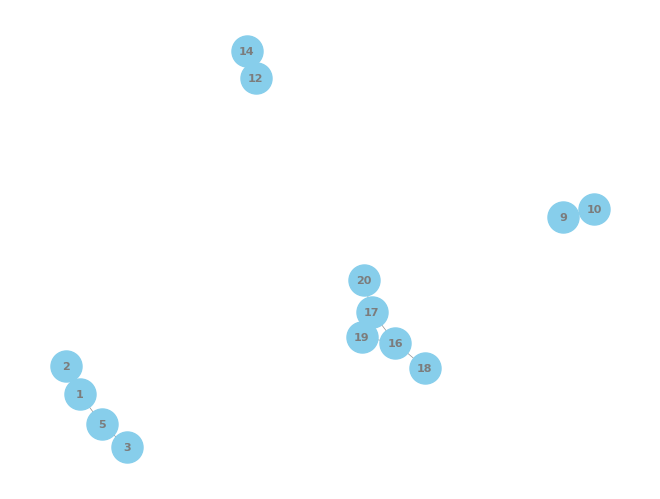

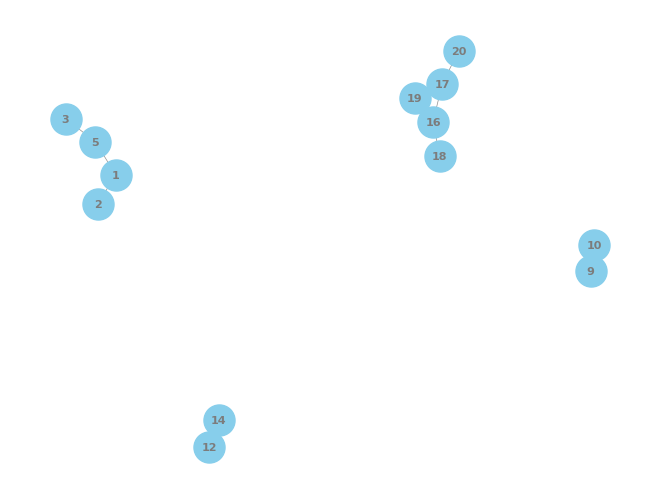

In [31]:
# Construct NetworkX graph
nx_graph = nx.Graph()
for row in graph.edges.collect():
    nx_graph.add_edge(row['src'], row['dst'])

# Visualize using matplotlib
pos = nx.spring_layout(nx_graph)
nx.draw(nx_graph, pos, with_labels=True, node_color='skyblue', node_size=500,
        edge_color='#909090', width=0.5, font_size=8, font_color='#7c7c7c',
        font_weight='bold')
plt.show()

print()

pos = nx.fruchterman_reingold_layout(nx_graph)
nx.draw(nx_graph, pos, with_labels=True, node_color='skyblue', node_size=500,
        edge_color='#909090', width=0.5, font_size=8, font_color='#7c7c7c',
        font_weight='bold')
plt.show()

### 3.2. Keep only one out of each group of similar processes and create the final filtered dateset

In [23]:
# Define the window specification for collecting members
window_spec_collect = Window.partitionBy("component")

# Define the window specification for ordering by id
window_spec_representative = Window.partitionBy("component").orderBy("id")

# Use row_number to get the representative
representatives_with_row_num = connected_components \
    .withColumn("row_num", row_number().over(window_spec_representative))

# Collect all ids of the connected components into a list, excluding the representative
connected_components_with_list = representatives_with_row_num \
    .withColumn("members", collect_list(
        when(col("row_num") != 1, col("id"))
    ).over(window_spec_collect))

# Filter for the representative and select the required columns
groups_with_members = connected_components_with_list \
    .where(col("row_num") == 1) \
    .select("id", "members")

In [24]:
groups_with_members.show()

+---+----------------+
| id|         members|
+---+----------------+
|  1|       [2, 3, 5]|
|  9|            [10]|
| 12|            [14]|
| 16|[17, 18, 19, 20]|
+---+----------------+



In [25]:
# Collect all the member lists into a single list
member_lists = groups_with_members.select("members").rdd.flatMap(lambda x: x).collect()

# Flatten the list of lists into a single list
ids_to_drop = list(chain.from_iterable(member_lists))

print(ids_to_drop)

[2, 3, 5, 10, 14, 17, 18, 19, 20]


In [26]:
# Delete grouped processes
filtered_df = logs_grouped.filter(~col("process_id").isin(ids_to_drop))

print(f'The original dataset had: {logs_grouped.count()} processes and we kept: {filtered_df.count()}')

The original dataset had: 20 processes and we kept: 11


In [27]:
filtered_df_strings = filtered_df.select(
    col("process_id"),
    concat(lit("["), concat_ws(",", col("from_servers")), lit("]")).alias("from_servers"),
    concat(lit("["), concat_ws(",", col("to_servers")), lit("]")).alias("to_servers"),
    concat(lit("["), concat_ws(",", col("times")), lit("]")).alias("times"),
    concat(lit("["), concat_ws(",", col("actions")), lit("]")).alias("actions")
)

In [28]:
filtered_df_strings.show(1, truncate=False)

+----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------+-------

In [29]:
filtered_df_strings.write.csv('results.csv', header=True, mode='overwrite')
